In [1]:
from pyarrow import fs, schema, string
from pyarrow.dataset import FilenamePartitioning
import pyarrow.dataset as ds
import boto3
import numpy as np
import pandas as pd
from datetime import datetime, timezone
from mats_utils.rawdata.read_data import read_MATS_data
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy import optimize
from scipy.interpolate import griddata
from scipy.spatial.transform import Rotation as R
import io
from PIL import Image, ImageFilter
from mats_l1_processing.read_parquet_functions import *
from mats_l1_processing.L1_calibration_functions import *
from mats_l1_processing import L1_calibrate
from mats_l1_processing.instrument import Instrument
from mats_l1_processing.read_parquet_functions import dataframe_to_ccd_items
from mats_utils.geolocation.coordinates import *
from mats_utils.geolocation import satellite as satellite
from skyfield import api as sfapi
import skyfield.sgp4lib as sgp4lib
from skyfield.framelib import itrs
from skyfield.positionlib import Geocentric
from pandas import concat, DataFrame

In [2]:
starttime = DT.datetime(2023,2, 13, 0, 30, 0)
endtime = DT.datetime(2023, 2, 13, 12, 45, 0)
df = read_MATS_data(starttime, endtime,filter=None,level='1b',version='0.4')


In [3]:
print('Number of images = ',df.shape[0])
clim=999
plt.close('all')
ccdnames=('IR1','IR4','IR3','IR2','UV1','UV2','NADIR')
flip=(True,False,True,False,True,True,False)
ir1=df[df.CCDSEL==1]
ir2=df[df.CCDSEL==4]
ir3=df[(df.CCDSEL==3)]
ir4=df[(df.CCDSEL==2)]
uv1=df[(df.CCDSEL==5)]
uv2=df[(df.CCDSEL==6)]
for ch in [ir1,ir2,ir3,ir4,uv1,uv2]:
    print (ccdnames[ch.CCDSEL.iloc[0]-1],  ch.shape[0])
ir1.shape

Number of images =  18
IR1 3
IR2 3
IR3 3
IR4 3
UV1 3
UV2 3


(3, 77)

In [4]:
def make_ths(ccditem):
    xpixels = np.linspace(0, ccditem['NCOL'], 5)
    ypixels = np.linspace(0, ccditem['NROW'], 10)
    ths = np.zeros([xpixels.shape[0], ypixels.shape[0]])
    print (ths.shape)
    for i,col in enumerate(xpixels): 
        ths[i,:]=col_heights(ccditem,col,40,spline=True)(ypixels)
    return xpixels,ypixels,ths.T

(5, 10)


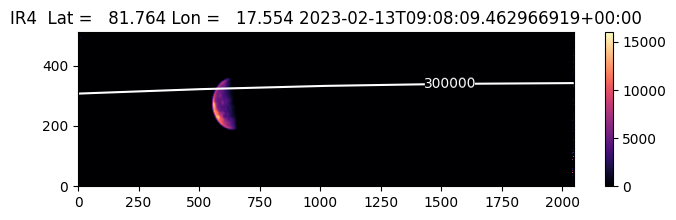

In [5]:

i=2

ch=ir4;clims=[0,16000]
#ch=ir2;clims=[0,1000]
#ch=ir4;clims=[0,60]
#ch=ir3;clims=[0,10]
#ch=uv1;clims=[0,8000]

fig,axis=plt.subplots(1,1,figsize=[8,2])
image=np.stack(ch.ImageCalibrated.iloc[i])
sp=plt.imshow(image, cmap="magma", origin="lower", interpolation="none")
axis.axis("auto")
TPlat,TPlon,satalt=satpos(ch.iloc[i])
plt.title("{:4s} Lat = {:8.3f} Lon = {:8.3f} {:s}".format(ccdnames[ch.iloc[i].CCDSEL - 1 ], TPlat, TPlon ,ch.EXPDate.iloc[i].isoformat()))
CS = axis.contour(*make_ths(ch.iloc[i]), [
                  50000,  60000, 70000, 80000, 90000, 100000, 110000,200000,250000,300000], colors='w')
axis.clabel(CS, inline=True)
plt.clim(clims)
plt.colorbar()
plt.show()

In [6]:
ts = sfapi.load.timescale()
planets = sfapi.load('de421.bsp')
earth = planets['Earth']
sun = planets['Sun']
moon= planets['moon']
ecipos = ch['afsGnssStateJ2000'][i][0:3]
d = ch['EXPDate'][i]
t = ts.from_datetime(d)
mats = Geocentric(position_au=Distance(m=ch['afsGnssStateJ2000'][i][0:3]).au, t=t)
st_vec=(earth+wgs84.subpoint(mats)).at(t).observe(moon).position.km

In [7]:
centrex = 2047./2
centrey = 510./2
xdispersion = 6.06 / 2047  # deg/pix
ydispersion = 1.52/510  # deg/pix
q = ch['afsAttitudeState'][i]
quat = R.from_quat(np.roll(q, -1))
qprime = ch['qprime'][i]
qprime = quat * R.from_quat(qprime)  #Rot.from_quat(qprimes[ch])
x, y = satellite.xyz2radec(np.expand_dims(qprime.inv().apply(st_vec), axis=1), deg=True)
x0 = int(x[0]/xdispersion + centrex)
y0 = int(-y[0]/ydispersion + centrey)
#print(ch['channel'][i],x,y,'corrected to ',x2,y)

In [8]:
radius=np.rad2deg(1738.1/norm(st_vec-ecipos/1000))/ydispersion
def circle(xc,yc,r,f=0):
    cir=[(xc+r*np.cos(th),yc+r*(1-f)*np.sin(th)) for th in np.linspace(0,2*np.pi,100) ]
    return cir

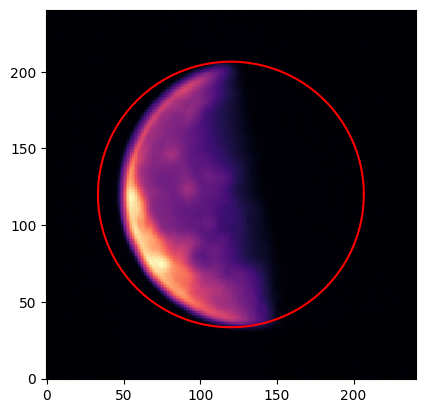

In [9]:
plt.figure()
box=120
testimage=image[y0-box:y0+box+1,x0-box:x0+box+1]
sp=plt.imshow(testimage, cmap="magma", origin="lower", interpolation="none")
axis.axis("auto")
cir=np.array(circle (box,box,radius,f=0.0012))
plt.plot(cir[:,0],cir[:,1],'r')

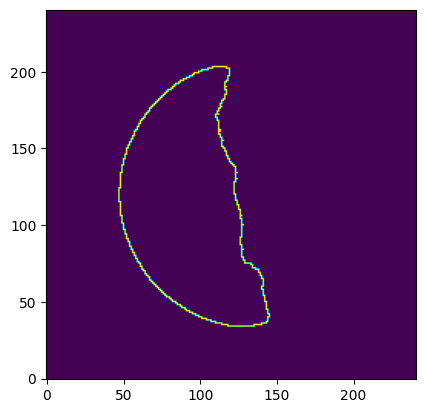

In [10]:
testimage[testimage<2000]=0 #get rid of noisy pixels
testimage=testimage.astype('int32')
test=Image.fromarray(testimage,mode='I')
test = test.convert("L")
edges = test.filter(ImageFilter.FIND_EDGES)
ared=np.array(edges)
plt.figure()
plt.imshow(edges,origin='lower')

In [11]:
def calc_R(xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_2(c):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(*c)
    return Ri - Ri.mean()
y,x=(ared[:,0:box-20]>10).nonzero()
x=x+1
y=y+1 #seems to find the outside of the edge så move one pixel
center_estimate = box, box
filter=np.abs(calc_R(*center_estimate)-radius)< 0.2*radius
x=x[filter]
y=y[filter]
center_2, ier = optimize.leastsq(f_2, center_estimate)
#Repeat filtering with better estimated of centre
y,x=(ared[:,0:box-10]>10).nonzero()
center_estimate = center_2
filter=np.abs(calc_R(*center_estimate)-radius)< 0.02*radius
x=x[filter]
y=y[filter]
center_2, ier = optimize.leastsq(f_2, center_estimate)
xc_2, yc_2 = center_2
xc_new,yc_new=center_2-[box,box]+[x0,y0]

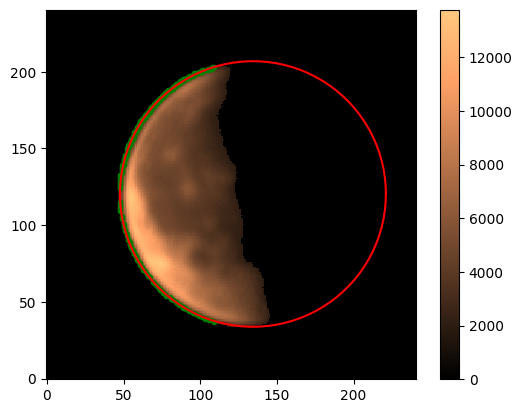

In [12]:
plt.figure()
sp=plt.imshow(testimage, cmap="copper", origin="lower", interpolation="none")
plt.colorbar()
axis.axis("auto")
cir2=np.array(circle (xc_2,yc_2,radius,f=0.0012))
plt.plot(x,y,'.g')
plt.plot(cir2[:,0],cir2[:,1],'r')

In [13]:
import scipy.interpolate as interp
f = interp.RectBivariateSpline(range(image.shape[0]), range(image.shape[1]), image, kx=2, ky=2)
new_im = f(yc_new+range(-box,box+1), xc_new+range(-box,box+1))

Text(0.5, 1.0, 'The moon in IR4 on 2023-08-13 09:08:09 x_pixel = 638.4')

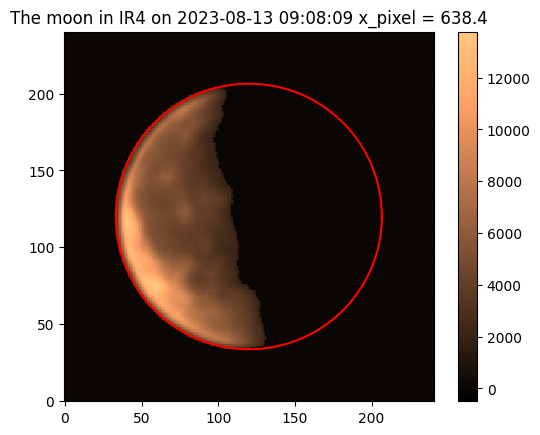

In [14]:
plt.figure()

sp=plt.imshow(new_im, cmap="copper", origin="lower", interpolation="none")
#plt.pcolor(new_im, cmap="magma")
axis.axis("auto")
#plt.clim(clims)
plt.colorbar()
cir2=np.array(circle (box,box,radius,f=0.0012))
#plt.plot(x,y,'.g')
plt.plot(cir2[:,0],cir2[:,1],'r')
plt.title("The moon in {} on {} x_pixel = {:4.1f}".format(ch['channel'][i],ch['EXPDate'][i].strftime ('%Y-%M-%d %X'),xc_new))

In [15]:
ch['EXPDate'][i].strftime ('%Y-%M-%d %X')

'2023-08-13 09:08:09'